In [129]:
import sys
import os
import argparse
import matplotlib.pyplot as plt
import math
import numpy as np
from itertools import product
from scipy.stats import binom
sys.path.append(os.path.abspath('./lib'))
from bcemetricspy import bce_lp, utils

parser = argparse.ArgumentParser(description="Robust identification in auctions!")
parser.add_argument("--num_bidders", dest="num_bidders", type=int, help='Number of bidders', default=2)
parser.add_argument("--max_value", dest="max_value", type=int, help='Support of values {0,1,2,...,max_value}', default=20)
parser.add_argument("--num_samples", dest="num_samples", type=int, help='Upper bound on BCE support size', default=100)
parser.add_argument("--max_trials", dest="max_trials", type=int, help='Maximum trials for BCE computation', default=20)
parser.add_argument("--random_seed", dest="random_seed", type=int, help='Random seed', default=1234)
parser.add_argument("--tolerance", dest="tolerance", type=float, help='Tolerance in best response constraints', default=0.0001)
parser.add_argument("--value_pdf_type", dest="value_pdf_type", 
                    type=str, help='Value distribution: {binom, uniform, random}', default='binom')
opts = parser.parse_args("")

num_bidders = opts.num_bidders
max_value = opts.max_value

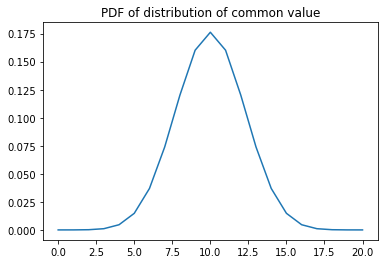

In [130]:
# Common value distribution
value_pdf = {
    'binom': np.ndarray.flatten(
        binom(n=max_value, p=.5).pmf([list(range(0, max_value + 1))])),
    'random': np.ndarray.flatten(np.abs(np.random.standard_normal(max_value + 1))),
    'uniform': np.ones(max_value + 1)
}.get(opts.value_pdf_type, np.abs(np.ndarray.flatten(np.random.standard_normal(max_value + 1))))
value_pdf = value_pdf / np.sum(value_pdf)

plt.plot(value_pdf)
plt.title("PDF of distribution of common value")
plt.show()

# Computing a BCE
We first compute a BCE for the given value distribution $\pi$. This is done by solving the following LP for $\phi$:

\begin{align}
LP(\phi,\pi) ~~~&~~~ \forall b_i^*,b_i'\in B:~& & \sum_{v\in V,~ {\bf b}\in B^n: b_i = b_i^*} \pi(v) \cdot x({\bf b} | v)\cdot \left(u_i({\bf b};v)-u_i(b_i',{\bf b}_{-i};v)\right) \geq 0\\
~~~&~~~ \forall {\bf b}\in B^n:~& & \phi({\bf b}) = \sum_{v\in V} \pi(v)\cdot x({\bf b}|v)\\
~~~&~~~ \forall v\in V:~& & x(\cdot|v) \in \Delta(B^n)
\end{align}

Apart from these constraints we will attempt to compute a BCE supported on a small subset of the bid vectors to decrease computation. This is based on the num_samples parameter.

In [131]:
# Compute an observed bid distribution from some BCE
bid_pdf = bce_lp.compute_bce(num_bidders, max_value,
                             value_pdf, num_samples=opts.num_samples,
                             max_trials=opts.max_trials, random_seed=opts.random_seed)

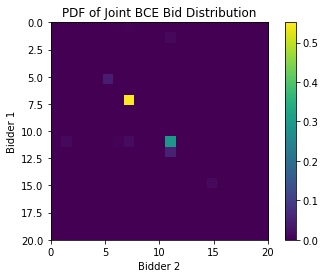

In [132]:
# Plot PDF of joint bid distribution
plt.figure()
joint_bid_dist = np.zeros((max_value + 1, max_value + 1))
for key in bid_pdf.keys():
    joint_bid_dist[int(key[0])][int(key[1])] = bid_pdf[key]
plt.imshow(joint_bid_dist, extent=(0, max_value, max_value, 0), interpolation='nearest')
plt.colorbar()
plt.xlabel("Bidder 2")
plt.ylabel("Bidder 1")
plt.title("PDF of Joint BCE Bid Distribution")
plt.show()

# Non-Parametric Sharp Identified Set on Moments

We now compute the upper and lower bound on the first two moments of the common value distribution, given that we observe the BCE distribution of bids. These functions solve two linear programs of the form:

\begin{align}
~~~&~~~ ~& \min/\max_{\pi} ~& \sum_{v\in V} \pi(v) \cdot m(v)\\
~~~&~~~ \forall b_i^*,b_i'\in B:~& & \sum_{v\in V,~ {\bf b}\in S: b_i = b_i^*} \phi({\bf b}) \cdot x(v ~|~ {\bf b})\cdot \left(u_i\left({\bf b};v\right)-u_i(b_i',{\bf b}_{-i};v)\right) \geq 0\\
~~~&~~~ \forall v\in V:~& & \pi(v) = \sum_{{\bf b}\in S} \phi({\bf b})\cdot x(v|{\bf b})\\
~~~&~~~ \forall {\bf b}\in S:~& & x(\cdot~|~{\bf b}) \in \Delta(V)
\end{align}

We also compute below loose upper and lower bounds on the mean. The upper bound is based on the work of Bergemann et al 2017 and the lower bound is simply the revenue of the observed BCE. 

In [133]:
# Compute a sharp identified set on the mean and second moment
non_param_lb_mean, non_param_ub_mean = bce_lp.inverse_bce(
    num_bidders, max_value, bid_pdf, utils.first_moment, tolerance=opts.tolerance)

non_param_lb_var, non_param_ub_var = bce_lp.inverse_bce(
    num_bidders, max_value, bid_pdf, utils.second_moment)

C:\ProgramData\Anaconda3\lib\site-packages\pulp-1.6.3-py3.6.egg\pulp\pulp.py:1335: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [134]:
# Print results
true_mean = np.dot(value_pdf, [utils.first_moment(v) for v in range(max_value + 1)])
true_var = np.dot(value_pdf, [utils.second_moment(v) for v in range(max_value + 1)])
revenue = sum([max(bids) * bid_pdf[bids] for bids in bid_pdf])
easy_bound = utils.brooks_bound(num_bidders, max_value, bid_pdf)

from IPython.display import display, Markdown, Latex
display(Markdown('#### NON-PARAMETRIC IDENTIFICATION RESULTS'))
display(Markdown("- Interval on mean: ({:.5}, {:.5}). True value of mean: {:.5}"
                 .format(non_param_lb_mean, non_param_ub_mean, true_mean)))
display(Markdown("- Interval on second moment: ({:.5}, {:.5}). True second moment: {:.5}"
                 .format(non_param_lb_var, non_param_ub_var, true_var)))
display(Markdown("- Inferred Standard deviation: ({:.5},{:.5}). True standard deviation: {:.5}".format(
    math.sqrt(max([lb_var - ub_mean**2, 0])),
    math.sqrt(ub_var - lb_mean**2),
    math.sqrt(true_var - true_mean**2))))
display(Markdown("- Revenue of BCE (lower bound on mean): {:.3}".format(revenue)))
display(Markdown("- BBM upper bound on mean: {:.5}".format(easy_bound)))

#### NON-PARAMETRIC IDENTIFICATION RESULTS

- Interval on mean: (8.7191, 10.602). True value of mean: 10.0

- Interval on second moment: (83.75, 212.03). True second moment: 105.0

- Inferred Standard deviation: (0.0,11.587). True standard deviation: 2.2361

- Revenue of BCE (lower bound on mean): 8.63

- BBM upper bound on mean: 17.645

# Parametric Identified Set

We now assume that the value distribution follows a parametric form. For simplicity here we consider a binomial distribution $B(n,p)$ with a known $n$, but unknown $p$. The parameter is then simply $p$. We construct the parametric identified set by going over a grid of this parameter and checking feasibility of the LP:

\begin{align}
~~~&~~~ \forall b_i^*,b_i'\in B:~& & \sum_{v\in V,~ {\bf b}\in S: b_i = b_i^*} \phi({\bf b}) \cdot x(v ~|~ {\bf b})\cdot \left(u_i\left({\bf b};v\right)-u_i(b_i',{\bf b}_{-i};v)\right) \geq 0\\
~~~&~~~ \forall v\in V:~& & \pi(v; p) = \sum_{{\bf b}\in S} \phi({\bf b})\cdot x(v|{\bf b})\\
~~~&~~~ \forall {\bf b}\in S:~& & x(\cdot~|~{\bf b}) \in \Delta(V)
\end{align}

where now the only free variables are the $x$, since $\pi(v;p)$ is determined by the parametric form. In fact, instead of checking feasibility, we instead compute the minimum violation of the constraints, i.e. the minimum $\tau$ such that all constraints are violated by at most $\tau$. We can then use this minimum violation for computing uncertainty sets for finite sample inference.

### Capped-Normal Parametric Form

In [151]:
# Parametric sharp identified set under a capped-normal parametric form
def normal_cdf(mu, sigma):
    density = np.array([np.exp(-(v - mu)**2 / (2 * sigma**2)) for v in range(max_value + 1)])
    density = density / np.sum(density)
    return density

# Grid of mu and sigma
mu_grid = np.arange(1, opts.max_value, 1)
sigma_grid = np.arange(1, opts.max_value, 1)
# Matrix of minimum constraint violations
tol_matrix = np.zeros((len(mu_grid), len(sigma_grid)))
# Go over grid
for i, j in product(*[range(len(mu_grid)), range(len(sigma_grid))]):
    # Solve parametric LP for these pararameters
    tol_matrix[i, j] = bce_lp.inverse_bce_parameterized_sparse_min_tolerance(
            num_bidders, max_value, bid_pdf, utils.first_moment, normal_cdf(mu_grid[i], sigma_grid[j]), solver_str='COIN')

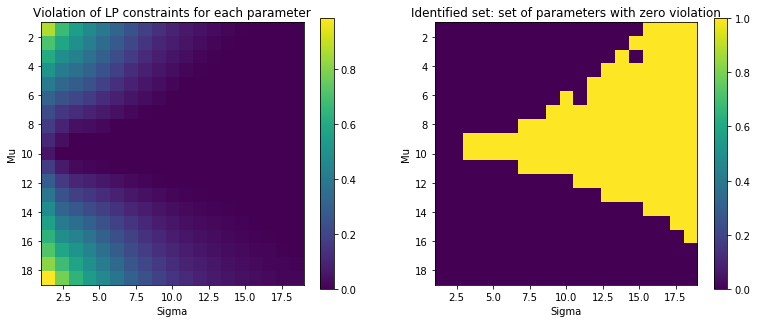

In [152]:
# Plot the identified set of mu,sigma
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(tol_matrix, extent=(np.min(sigma_grid), np.max(sigma_grid), np.max(mu_grid), np.min(mu_grid)), interpolation='nearest')
plt.colorbar()
plt.xlabel("Sigma")
plt.ylabel("Mu")
plt.title("Violation of LP constraints for each parameter")
plt.subplot(1,3,2)
plt.imshow(tol_matrix==0, extent=(np.min(sigma_grid), np.max(sigma_grid), np.max(mu_grid), np.min(mu_grid)), interpolation='nearest')
plt.colorbar()
plt.xlabel("Sigma")
plt.ylabel("Mu")
plt.title("Identified set: set of parameters with zero violation")
plt.show()

In [153]:
# Compute upper and lower bounds on the mean based on the parametric identified set
parametric_lb_mean = 10**6
parametric_ub_mean = 0
for i, j in product(*[range(len(mu_grid)), range(len(sigma_grid))]):
    if  tol_matrix[i][j] <= 0:
        mean = np.dot(normal_cdf(mu_grid[i], sigma_grid[j]), np.arange(max_value+1))
        if mean <= parametric_lb_mean:
            parametric_lb_mean = mean
        if mean >= parametric_ub_mean:
            parametric_ub_mean = mean

from IPython.display import display, Markdown, Latex
display(Markdown('#### PARAMETRIC IDENTIFICATION RESULTS'))
display(Markdown("- Parametric-Based Interval on mean: ({:.5}, {:.5}).\
                 True value of mean: {:.5}".format(parametric_lb_mean, parametric_ub_mean, true_mean)))

#### PARAMETRIC IDENTIFICATION RESULTS

- Parametric-Based Interval on mean: (8.7465, 10.595).                 True value of mean: 10.0

### Binomial Parametric Form

In [159]:
# Parametric sharp identified set under a binomial parametric form
def parametric_cdf(param):
    density = np.ndarray.flatten(binom(n=max_value, p=param).pmf([list(range(0, max_value + 1))]))
    density = density / np.sum(density)
    return density

# Grid of p
param_grid = np.arange(0.1, 1, 0.01)
# Matrix of minimum constraint violations
tol_matrix = np.zeros(len(param_grid))
# Go over grid
parametric_lb_mean = 10**6
parametric_ub_mean = 0
for i in range(len(param_grid)):
    # Solve parametric LP for these pararameters
    tol_matrix[i] = bce_lp.inverse_bce_parameterized_sparse_min_tolerance(
            num_bidders, max_value, bid_pdf, utils.first_moment, parametric_cdf(param_grid[i]), solver_str='COIN')
    if tol_matrix[i] <= 0:
        mean = np.dot(parametric_cdf(param_grid[i]), np.arange(max_value+1))
        if mean <= parametric_lb_mean:
            parametric_lb_mean = mean
        if mean >= parametric_ub_mean:
            parametric_ub_mean = mean


from IPython.display import display, Markdown, Latex
display(Markdown('#### PARAMETRIC IDENTIFICATION RESULTS'))
display(Markdown("- Parametric-Based Interval on mean: ({:.5}, {:.5}).\
                 True value of mean: {:.5}".format(parametric_lb_mean, parametric_ub_mean, true_mean)))

#### PARAMETRIC IDENTIFICATION RESULTS

- Parametric-Based Interval on mean: (10.0, 10.2).                 True value of mean: 10.0

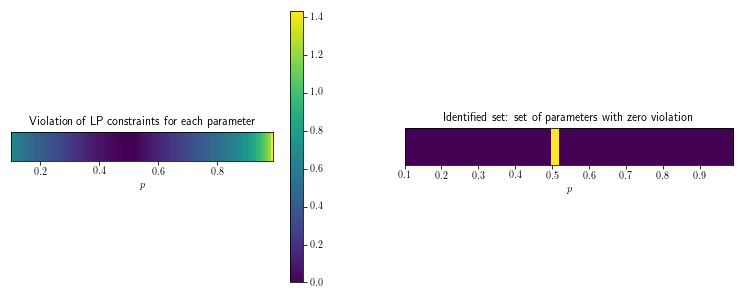

In [178]:
# Plot the identified set of mu,sigma
plt.figure(figsize=(20,5))
plt.rc('text', usetex=True)
plt.subplot(1,3,1)
plt.imshow(tol_matrix.reshape(1,-1), extent=(np.min(param_grid), np.max(param_grid), 0, .1), interpolation='nearest')
plt.colorbar()
plt.xlabel(r"$p$")
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Violation of LP constraints for each parameter")
plt.subplot(1,3,2)
plt.rc('text', usetex=True)
plt.imshow(tol_matrix.reshape(1,-1)==0,  extent=(np.min(param_grid), np.max(param_grid), 0, .1), interpolation='nearest')
plt.xlabel("$p$")
plt.title("Identified set: set of parameters with zero violation")
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()